In [1]:
import sys
import os
import matplotlib
import warnings
warnings.filterwarnings('ignore') #dette er bare for å skjule skrift warnings mtp. bruk av skrift type osv
matplotlib.rcParams['font.family'] = 'DejaVu Sans'


notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(os.path.join(project_root, 'src'))


from data_visualizations.dataframes import build_dataframe_from_json, build_dataframe_from_db
from data_visualizations.nilu import nilu_plotly, get_cleaned_data_path


json_df = build_dataframe_from_json('cleaned_data_nilu.json')
db_df = build_dataframe_from_db('frost.db', 'weather_data')
nilu_plotly = nilu_plotly(get_cleaned_data_path('cleaned_data_nilu.json'))

---

## 1. Del 1: Beskrivende Statistikk

For å forstå datasettet og kvaliteten på dataene, er det viktig å beregne sentrale statistiske mål som **gjennomsnitt**, **median** og **standardavvik**. Disse tallene gir oss et bilde av hvordan dataene fordeler seg, om det finnes uteliggere, og hvor mye variasjon det er i målingene.

Eksempel med prosjektdata:

```python
import pandas as pd
import numpy as np
import sqlite3

# Funksjon for å hente og bearbeide data fra databasen
def load_and_prepare_data(db_path: str) -> pd.DataFrame:
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql('SELECT * FROM weather_data', conn)
    return df

# Leser inn data fra prosjektets database
df = load_and_prepare_data('data/clean/frost.db')

# Eksempelkolonne: Gjennomsnittstemperatur
temperatur = df['mean_air_temperature']

# Pandas
print("Gjennomsnitt (Pandas):", temperatur.mean())
print("Median (Pandas):", temperatur.median())
print("Standardavvik (Pandas):", temperatur.std())

# NumPy
print("Gjennomsnitt (NumPy):", np.mean(temperatur))
print("Median (NumPy):", np.median(temperatur))
print("Standardavvik (NumPy):", np.std(temperatur, ddof=1))  # ddof=1 matcher Pandas
```

**Hvorfor er disse statistiske målene viktige?**

- **Gjennomsnitt (mean)** gir et mål på den "typiske" verdien i datasettet, men kan påvirkes av ekstreme verdier (uteliggere).
- **Median** er den midterste verdien når dataene er sortert, og er robust mot uteliggere.
- **Standardavvik** viser hvor mye verdiene i datasettet varierer rundt gjennomsnittet. Et høyt standardavvik betyr stor variasjon, et lavt standardavvik betyr at verdiene ligger tett rundt gjennomsnittet.

Disse målene hjelper oss å forstå datasettet på en enkel måte, og oppdage om det finnes unormale verdier eller stor variasjon. 

---

### 🌦️ - Været i Trondheim
Nå går vi fra luftkvalitet til værdata og skal undersøke været i Trondheim de siste årene. Som med luftkvaliteten starter vi med å analysere statistikken for å få en god oversikt over dataene. 

In [2]:
# Hente inn dataframe for Frost
print(db_df)

  referenceTime  mean_air_temperature  mean_wind_speed  total_precipitation  generated_mean_air_temperature  generated_mean_wind_speed  generated_total_precipitation
0    2010-01-01                 -10.0              1.6                  2.1                               0                          0                              0
1    2010-01-02                 -13.5              2.6                  0.1                               0                          0                              0
2    2010-01-03                  -2.3              3.0                  1.1                               0                          0                              0
3    2010-01-04                  -4.7              2.8                  7.9                               0                          0                              0
4    2010-01-05                 -15.8              2.7                  0.4                               0                          0                              0
5   

### 🌫️ - Luftkvaliteten i Trondheim
Først skal vi få oversikt over statistiske verdier som gjennomsnitt, median og standaravvik over ulike luftkvalitets indikatorer, som gir oss en rask oversikt over dataens fordeling, variasjon og typiske verdier. Dette hjelper oss med å forstå dataen og identifisere eventuelle avvik eller mønstre.

**DataFrame over luftkvalitet**

In [3]:
from data_visualizations.dataframes import build_dataframe_from_json, build_dataframe_from_db
print(json_df)

     dateTime   NO2  PM10  PM2.5  generated_NO2  generated_PM10  generated_PM2.5
0  2010-01-01  25.7  39.1   11.8          False           False             True
1  2010-01-02  26.8  30.9   30.5          False           False            False
2  2010-01-03  13.3   9.7    8.6          False           False            False
3  2010-01-04  47.7  23.7   20.8          False           False            False
4  2010-01-05  47.5  25.8   24.9          False           False            False
5  2010-01-06  59.3  39.9    7.8          False           False             True


---

# Del 2 - Dataanalyse og Visualisering – Når Tall Blir til Fortellinger 📊

Velkommen til den mest visuelle delen av prosjektet vårt! Etter å ha samlet inn, renset og analysert miljødata, er det nå på tide å la tallene **snakke for seg selv**. Med grafer og diagrammer gjør vi dataene mer forståelige – og viser hva de faktisk forteller oss om miljøet i Trondheim 🌦️

## Dette skal vi gjøre:

### 1. Værdata fra Frost ❄️🌧️
Vi ser på temperatur, nedbør og vind. Ved hjelp av grafer undersøker vi:
- Sesongvariasjoner og langsiktige trender
- Hvordan enkeltmålinger fordeler seg
- Et tydelig bilde av Trondheims vær over tid

### 2. Luftkvalitet fra NILU 🫁
Vi analyserer konsentrasjonene av:
- **NO₂**
- **PM10**
- **PM2.5**
- **sammenheng mellom NO2 og PM10**

Vi visualiserer daglige og månedlige svingninger, identifiserer perioder med høy forurensning og ser på hvordan partiklene fordeler seg i lufta.

### 3. Sammenhengen mellom vær og luftkvalitet 🌬️🔗
Hvordan påvirker været luftkvaliteten? Vi lager kryss-visualiseringer for å se sammenhenger mellom:
- Temperatur og forurensningsnivåer
Dette gir oss innsikt i hvordan ulike miljøfaktorer henger sammen.

---

## Verktøy vi bruker 🛠️

- **Matplotlib** og **Seaborn**: For klare og informative statiske grafer.
- **Plotly**: For interaktive visualiseringer hvor vi kan zoome, filtrere og utforske mer i dybden.

Disse verktøyene hjelper oss ikke bare med å vise data, men også med å **fortelle historien** bak dem – en historie om Trondheims miljø, og hvordan det utvikler seg over tid.

---


#### Figur 1: Interaktiv Værdata-utforskning for Trondheim (2010-2019) 🌐📊☁️

Her starter vi med en interaktiv graf som gir deg full kontroll over ti år med værdata fra Frost. Plotly-plottet gjør tørre, statiske tall om til et levende verktøy for å utforske temperatur, nedbør og vindhastighet i Trondheim mellom 2010 og 2019.

**Formål:**  
Grafen gir et helhetlig og dynamisk overblikk over sentrale værparametere. Den lar deg navigere og utforske dataene på egne premisser, slik at du kan oppdage mønstre og detaljer som ellers ville vært vanskelig å se etter i en statistik tabell. (dette gjelder også alle andre interaktive grafer videre i analysen)

- **Lesbarhet:** Akser og etiketter er tydelig merket, og fargebruk gjør det enkelt å skille mellom variablene.
- **Estetikk:** Layouten er ren og konsistent, og fremhever viktige mønstre uten visuell støy.
- **Formidling:** Tidsserien viser sesongvariasjon og ekstreme hendelser godt, noe som underbygger analysene våre senere i rapporten.



In [4]:
from data_visualizations.frost_visualization.frost import plot_weather_data
plot_weather_data('../data/clean/frost.db')


**Fordeler med en slik figur:**
* **Detaljert innsikt:** Se hvordan temperaturer svinger, observer nedbørsmengder og identifiser vindtopper over tid.
* **Dynamisk utforskning:**
    * **Filtrering:** Velg spesifikke parametere (temperatur, nedbør, vindhastighet) for fokusert analyse.
    * **Tidsnavigering:** Zoom inn på korte perioder (dager, uker) eller ut for å se langsiktige trender over hele tiåret.
    * **Nøyaktige verdier:** Hold musepekeren over datapunkter for presis dataavlesning.
* **Forbedret forståelse:** Interaktiviteten forbedrer datatolkningen ved å tillate tilpasset visning og dypere dykk i detaljene. Den gir en mer engasjerende og effektiv måte å formidle kompleks informasjon, og gir brukeren verktøy til å selv utforske.

---


#### Figur 2: Daglig Utvikling av Temperatur, Nedbør og Vindhastighet i Trondheim 📈💨💧

Etter å ha sett på den interaktive værdataen, går vi nå nærmere inn på hvordan temperatur, nedbør og vindhastighet endrer seg dag for dag. Vi bruker en serie scatterplott med en linje som viser den generelle trenden. Denne typen graf er veldig bra for å vise tidsserier fordi den viser både de enkelte datapunktene og den overordnede utviklingen.

**Figurens formål:**  
Disse plottene skal:  
* Vise hvordan værparametere endrer seg daglig.  
* Finne generelle trender og sesongmønstre i været.  
* Se hvor mye dataene spriker rundt trendene.


- **Lesbarhet:** Fargevalg og regresjonslinjer er intuitive og godt tilpasset. Grafene er delt opp logisk.
- **Estetikk:** Rent og moderne uttrykk – enkelt å lese selv med mange datapunkter.
- **Formidling:** Regresjonslinjene gir en visuell pekepinn på hvordan været har utviklet seg, noe som styrker tolkningen.


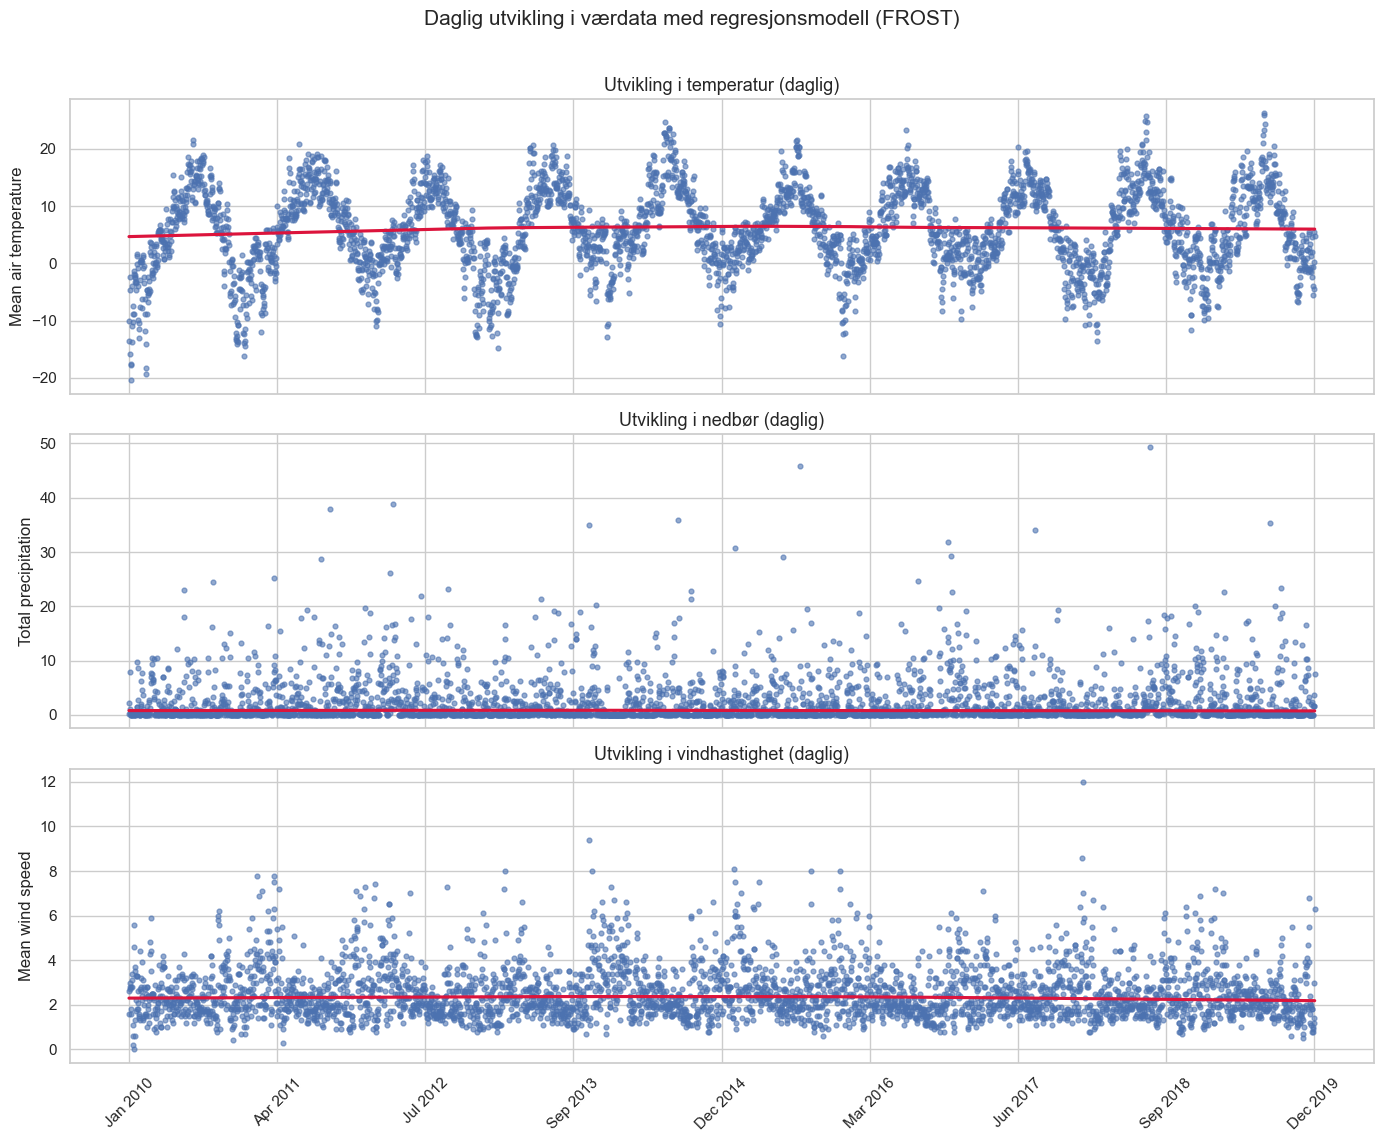

In [5]:
from data_visualizations.frost_visualization.daily_weather_trend_regression import plot_weather_components
plot_weather_components("../data/clean/frost.db")

**Analyse av figuren:**  

* **Temperaturutvikling:**  
    * Grafen viser en tydelig sesongsyklus, med høye temperaturer om sommeren og lave om vinteren, typisk for et sted med fire årstider.  
    * Linjen som viser trenden er nesten helt flat, noe som betyr at gjennomsnittstemperaturen ikke har gått opp eller ned over tid. Endringene skyldes sesongene, ikke en langvarig trend.  
    * Punktspredningen viser hvor mye temperaturen varierer fra dag til dag.

* **Nedbørsutvikling:**  
    * Grafen for nedbør er veldig spredt, med mange dager uten regn (punkter ved null) og noen få dager med mye regn.  
    * Trendlijnjen er også flat, som betyr at mengden nedbør ikke har økt eller minket over tid. Nedbørsmønsteret er stabilt, men variabelt.  
    * Stor spredning viser at nedbør er vanskelig å forutsi fra dag til dag.

* **Vindhastighetsutvikling:**  
    * Grafen viser lave vindhastigheter de fleste dager, men også enkelte topper med sterk vind.  
    * Trendlijnjen er flat, som betyr at vindstyrken har holdt seg ganske stabil over tid.  
    * Toppene viser kortvarige, sterke vindkast som skiller seg fra vanlig vind.

**Innsikt og relevans for Trondheims vær:**  
Disse grafene gir en god visuell forståelse av været i Trondheim. De bekrefter klare sesongmønstre og at gjennomsnittsværet har vært stabilt over tid. Spredningen rundt trendlinjene viser hvor uforutsigbare værparametrene kan være. Dette gir viktig støtte til den statistiske analysen og gir et godt grunnlag for videre vurderinger av miljøet.



---

#### Figur 3: Månedlig Fordeling av Temperatur i Trondheim (Boxplot) 🌡️📊

Her viser vi temperaturvariasjonene i Trondheim gjennom årene (samlet snitt av hver måned, hvert år) med en boxplot som viser den daglige middeltemperaturen per måned. 

Denne figuren viser oss et "bilde" av hvordan temperaturen typisk er hver måned. Hvert "boks" og "strek" i figuren forteller oss noe viktig:

* **Boksen i midten:** Denne boksen viser deg hvor *de fleste* temperaturene for den måneden ligger. Tenk at halvparten (50%) av alle temperaturmålingene for den måneden faller innenfor denne boksen.
    * **Midtstreken i boksen (Median / Q2):** Denne streken er den *typiske* temperaturen for måneden. Akkurat halvparten av alle temperaturmålingene er lavere enn denne streken, og halvparten er høyere. Vi kaller dette **medianen**.
    * **Bunnen av boksen (Q1):** Denne linjen forteller deg at 25% av temperaturmålingene er *lavere* enn denne verdien.
    * **Toppen av boksen (Q3):** Denne linjen forteller deg at 75% av temperaturmålingene er *lavere* enn denne verdien (eller 25% er *høyere*).

* **Strekene som stikker ut fra boksen ("whiskers"):** Disse "værhårene" viser deg hvor langt de *normale* temperaturene strekker seg. De viser deg de laveste og høyeste temperaturene vi forventer å se, utenom de helt ekstreme tilfellene.

* **Prikker utenfor strekene:** prikker utenfor "værhårene", betyr det at dette er *ekstreme* temperaturer. Det kan være uvanlig varme eller kalde dager som ligger langt utenfor det normale for den måneden.

- **Lesbarhet:** Klar struktur per måned. Median og whiskers er tydelige.
- **Estetikk:** Fargene fremhever forskjellene uten å overvelde, og gjør figuren visuelt engasjerende.
- **Formidling:** Gir et presist bilde av temperaturspennet og gjør det enkelt å identifisere uvanlige måneder.

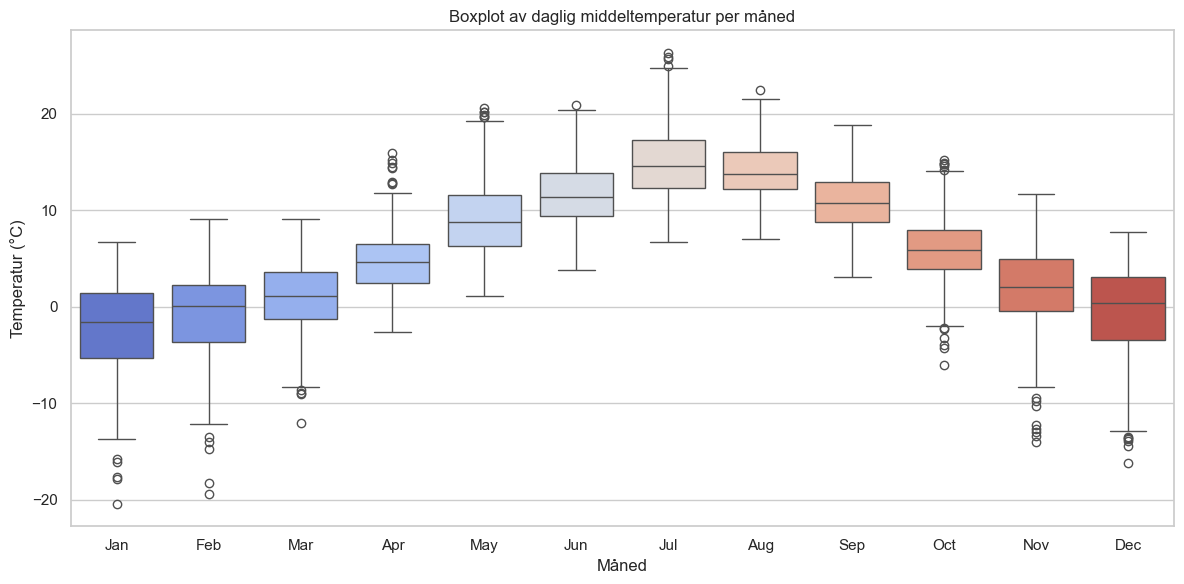

In [6]:
from data_visualizations.frost_visualization.temperature_boxplot import vis_temp_per_måned
vis_temp_per_måned("../data/clean/frost.db")

#### Analyse av figuren

* **Tydelig sesongprogresjon:**  
    * Median temperatur viser en klar og forutsigbar utvikling gjennom året: starter godt under 0°C om vinteren (januar, februar), stiger jevnt om våren, når toppnivå rundt 15–20°C om sommeren (juli, august), og synker igjen mot høsten. Dette bekrefter de vanlige årstidene i Trondheim.

* **Variasjon og stabilitet:**  
    * Måneder som april, august og september har smalere bokser, som betyr mindre dag-til-dag variasjon og mer stabil temperatur.  
    * Februar har en av de største spredningene (lange whiskers), noe som tyder på at selv om temperaturen ofte er stabil, forekommer det tidvis større svingninger.

* **Outliers og ekstreme verdier:**  
    * Figuren viser nå også uteliggere (små sirkler utenfor whiskers). Disse representerer dager med uvanlig lave eller høye temperaturer sammenlignet med resten av måneden.
    * Ved å inkludere uteliggere får vi et mer komplett bilde av temperaturvariasjonene i Trondheim, og det blir mulig å identifisere både ekstremvær og mulige målefeil.
    * Uteliggere forekommer særlig i vintermånedene, noe som er forventet i et klima med potensielt kraftige kuldeperioder.

**Innsikt og relevans for Trondheims klima:**  
Boxplotten gir både oversikt over normal temperaturfordeling og synliggjør ekstreme hendelser. Dette gir et helhetlig bilde av både typiske og uvanlige temperaturer gjennom året, og styrker analysen fordi vi kan diskutere betydningen av slike uteliggere – om de skyldes værfenomener eller datakvalitet. Sammenligning mellom månedene viser tydelig når Trondheim har mest stabile temperaturer og når variasjonen er størst.

#### Figur 4: Gjennomsnittlig Daglig Nedbør per Måned (med Standardavvik) 💧📊

Her vises et søylediagram/histogram som illustrerer gjennomsnittlig daglig nedbør i millimeter for hver måned. Søylene viser gjennomsnittet, mens feilfeltene viser standardavviket – altså hvor mye nedbørsmengden varierer fra dag til dag i hver måned. Dette gjør det enkelt å sammenligne både gjennomsnitt og variasjon mellom månedene.

**Figurens formål:**  
Denne figuren skal:  
* Vise den årlige syklusen for daglig nedbør.  
* Kvantifisere hvor mye nedbøren varierer innen hver måned.  
* Gjøre det lett å finne de tørreste, våteste og mest ustabile periodene i året.


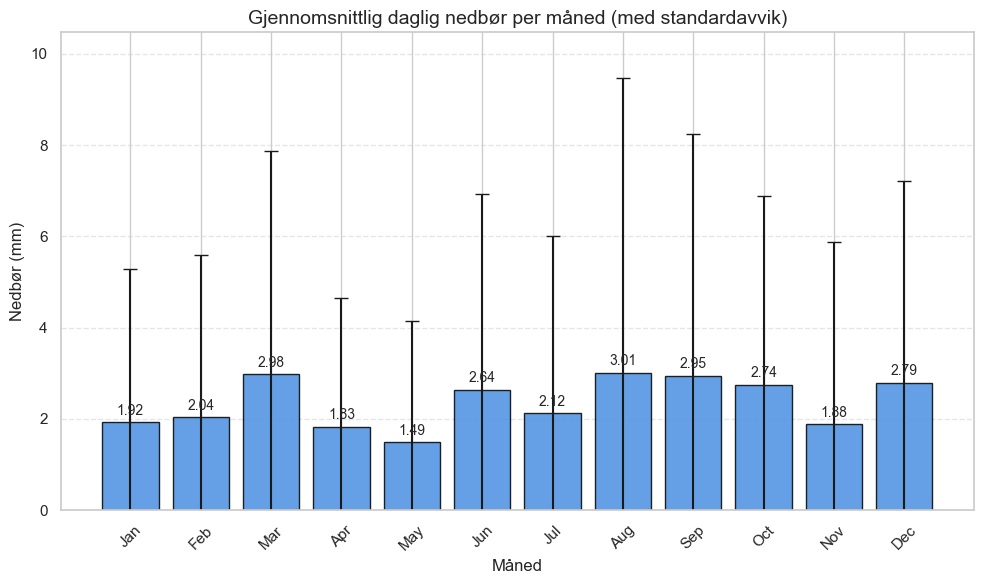

In [7]:
from data_visualizations.frost_visualization.precipitation_histogram import vis_nedbør_pr_måned
vis_nedbør_pr_måned("../data/clean/frost.db")

#### Analyse av figuren:

* **Høy- og lavnedbørsperioder:**  
    * August har høyest gjennomsnittlig daglig nedbør med **3,01 mm**, tett etterfulgt av mars (**2,98 mm**) og september (**2,95 mm**). Det betyr at de våteste periodene ikke er samlet i én enkelt sesong.  
    * Mai har lavest gjennomsnitt med bare **1,49 mm**, mens april (**1,83 mm**) og november (**1,88 mm**) også er relativt tørre.

* **Variasjon i nedbør (standardavvik):**  
    * Feilfeltene viser at de våteste månedene – august, september og mars – også har størst variasjon i nedbør fra dag til dag.  
    * De tørreste månedene, spesielt mai, har lavest variasjon, noe som betyr at nedbøren er mer jevn og forutsigbar da.

**Oppsummering:**  
Denne figuren gir et klart bilde av når på året Trondheim opplever mest og minst nedbør, samt hvor stabilt eller uforutsigbart nedbøret er i hver måned. Dette er viktig for å forstå både klima og praktiske utfordringer knyttet til værforhold.

---


#### Figur 5: Interaktiv Analyse av Klimavariabler over Tid 📈

**Formål:**  
Denne interaktive figuren gir brukeren mulighet til å utforske klimadata etter sesong. Den viser og sammenligner trender og variasjoner i temperatur, nedbør og vind over de fire årstidene. Målet er å enkelt kunne identifisere avvik som uvanlig varme somrer eller kalde vintre i perioden.


- **Lesbarhet:** Brukervennlig grensesnitt med gode akseetiketter og interaktive filtre.
- **Estetikk:** Interaktivt oppsett med hover-informasjon og fargekoding gjør det intuitivt og informativt.
- **Formidling:** Hjelper brukeren til å identifisere sesongmønstre og dykke dypere i spesifikke perioder.

In [8]:
from data_visualizations.frost_visualization.frost_interactive_visualization import plot_seasonal_weather_from_sqlite
plot_seasonal_weather_from_sqlite("../data/clean/frost.db")

#### Analyse


**Tydelige Sesongprofiler**

Figuren viser tydelig den sterke sesongprofilen til **temperaturen** (blå linje), med en forutsigbar syklus fra kalde vintre til varme somre. **Nedbør** (rød linje) og **vindhastighet** (grønn linje) har derimot mindre forskjell mellom sesongene, og holder seg relativt stabile gjennom året. Dette understreker at disse variablene påvirkes av andre faktorer og har en mer ujevn sesongvariasjon sammenlignet med temperatur.

**Årlige Trender og Variasjon**

Gjennom tiårsperioden er det svingninger i temperatur, spesielt synlig i sommersesongen der 2014 og 2019 fremstår som merkbart varmere enn de andre årene. Man kan også observere en ekstra kald vinter tidlig i tiåret. For nedbør og vindhastighet er variasjonen mellom år og sesonger langt mindre tydelig, og de holder seg stort sett på samme nivå. 

**oppsummering**
Figuren gir derfor et godt bilde av hvordan temperatur har en markant sesongsyklus, mens nedbør og vindhastighet varierer mindre og mer uregelmessig gjennom året og mellom årene.

---

## 🔚 Oppsummering: Værdata fra Frost – Innsikt og Konklusjoner

Etter å ha analysert ti år med daglige værdata fra Trondheim gjennom Frost API, har vi fått et solid og detaljert bilde av de viktigste klimavariablene – temperatur, nedbør og vind. Både statiske visualiseringer og interaktive verktøy har vært brukt for å belyse sesongvariasjoner, ekstreme verdier, og underliggende mønstre i byens værbilde.

### 🌡️ Temperatur
- Temperaturdataene viser en **tydelig sesongsyklus**, med laveste verdier i januar–februar og høyest i juli–august.
- **Regresjonsanalysen viser ingen signifikant lineær trend**, noe som tyder på at temperaturendringer i perioden 2010–2019 har vært sesongbaserte og stabile over tid.
- Boxplotten gir en god oversikt over **forutsigbarhet og spredning** fra måned til måned – hvor spesielt vår- og høstmånedene peker seg ut som mer stabile.

### 💧 Nedbør
- Nedbørsmønsteret er **mer uforutsigbart**, med store variasjoner både mellom måneder og fra dag til dag.
- **Ingen klar økning eller reduksjon** i gjennomsnittlig daglig nedbør over tid.
- Standardavvikene i månedlig nedbør viser at selv de våteste månedene (som august og mars) er preget av betydelig dag-til-dag-variabilitet, mens de tørreste (som mai) har lavere varians og mer forutsigbart vær.

### 💨 Vindhastighet
- Vindhastighet er jevnt lav, med enkelte dager som skiller seg ut med kraftige vindkast.
- Også her peker regresjonslinjene på **stabilitet over tid**, uten noen tydelig økning i intensitet eller frekvens.

### 🧠 Oppsummert
Trondheim har et stabilt og forutsigbart årsklima når det gjelder temperatur, mens både nedbør og vind utviser større grad av tilfeldig variasjon. Ingen av parameterne viser tydelige tegn på langsiktige trender i denne tiårsperioden. Samlet sett gir datasettene fra Frost et robust fundament for å forstå klimatiske forhold i regionen, med klare sesongprofiler og innslag av naturlig variasjon.

---

## Del 3 - Luftkvalitet i Trondheim – Hva Puster Vi Inn? 🫁 

Vær og klima er bare én side av miljøbildet. For å få et mer komplett bilde av de fysiske omgivelsene i Trondheim, retter vi nå blikket mot **luftkvalitet**. Gjennom data hentet fra NILU (Norsk institutt for luftforskning) skal vi undersøke nivåene av svevestøv, nitrogendioksid og andre luftforurensende komponenter i byluften.

Hvordan endrer luftkvaliteten seg med sesong, vær og år? Hvilke områder og perioder peker seg ut med dårligst luft? Og hvordan henger dette sammen med det vi har sett i klimadataene?

Dette skal vi svare på i den neste delen.

#### **Figur 1: Interaktiv Oversikt over Luftkvalitetsdata** 🌫️📉

Analysen av luftkvalitetsdataene innledes med denne interaktive oversiktsfiguren, som viser den komplette og ufiltrerte tidsserien for de daglige målingene av **NO₂**, **PM10** og **PM2.5** i Trondheim. Ved hjelp av interaktive funksjoner som tidsvelger og zoom-linjal, gir figuren en kraftig og intuitiv mulighet til å utforske rådataene i dybden og få en umiddelbar forståelse av deres struktur og dynamikk.


- **Lesbarhet:** Hover-effekter og zoom gjør det enkelt å studere detaljerte perioder.
- **Estetikk:** Bruk av farge og layout gjør dataene levende og engasjerende.
- **Formidling:** Interaktiviteten støtter utforskning av forurensningstopper og korrelasjon med tidspunkter.

In [9]:
# Hente inn ploty over NILU
nilu_plotly.show()

### 🔍 Hva figuren viser:
Allerede ved første øyekast avdekker visualiseringen flere kritiske innsikter:

- **Ekstremt tydelig sesongvariasjon**: Hver vinter oppstår det systematiske og markante topper i luftforurensningen, særlig for PM10 og NO₂. Dette mønsteret gjentar seg årlig, og peker på klima- og atferdsbetingede drivere (f.eks. kulde, svevestøv fra piggdekk, fyring og stillestående luft).
  
- **Høy dag-til-dag-variabilitet**: Dataene er preget av betydelig "støy", med store variasjoner selv innenfor korte tidsintervaller. Dette indikerer behovet for aggregering, glatting og modellering for å avdekke langsiktige trender bak den kortsiktige fluktuasjonen.

- **Klar samvariasjon mellom komponentene**: NO₂, PM10 og PM2.5 ser ut til å bevege seg i takt. Når én komponent øker, gjør gjerne de andre det også – noe som tyder på at de deler felles kilder eller påvirkes av felles værforhold.

### 🧭 Hvorfor denne figuren er viktig:
Denne interaktive oversikten fungerer som **utgangspunktet for videre analyse**. Den gjør det mulig å:

- Fange opp årstidsavhengige mønstre tidlig.
- Identifisere ekstreme hendelser og enkeltår med avvikende nivåer.
- Få en rask og intuitiv følelse for datamengden, variasjonen og kompleksiteten som ligger til grunn for luftkvalitetsbildet i Trondheim.

Denne eksplorerende figuren setter med andre ord rammen for det som kommer: en detaljert, datadrevet gransking av hvordan luftforurensningen utvikler seg over tid, hva som driver variasjonene – og hvordan dette påvirker bymiljøet.

---


#### **Figur 2: Langsiktig Trendanalyse av Luftforurensning (NILU-data) 📉**

Denne figuren presenterer en detaljert analyse av den daglige utviklingen i luftforurensning for komponentene **NO₂**, **PM10** og **PM2.5** i Trondheim i perioden ca. **2010–2024**. Visualiseringen består av tre separate tidsserieplott, hvor hvert blått punkt representerer én dags måling. Den mest sentrale komponenten i hvert plott er den **røde linjen**, som representerer en lineær regresjonsmodell – en statistisk teknikk brukt til å identifisere underliggende trender bak daglig og sesongmessig variasjon.

**Formål med figuren:**

Denne visualiseringen er utviklet for å:

- Fremheve den faktiske dag-til-dag variasjonen i luftforurensningsnivåene.
- Kvantifisere og visualisere langsiktige trender i luftkvaliteten ved hjelp av regresjonsanalyse.
- Synliggjøre de repeterende, årstidsavhengige mønstrene som er karakteristiske for byens luftkvalitet.

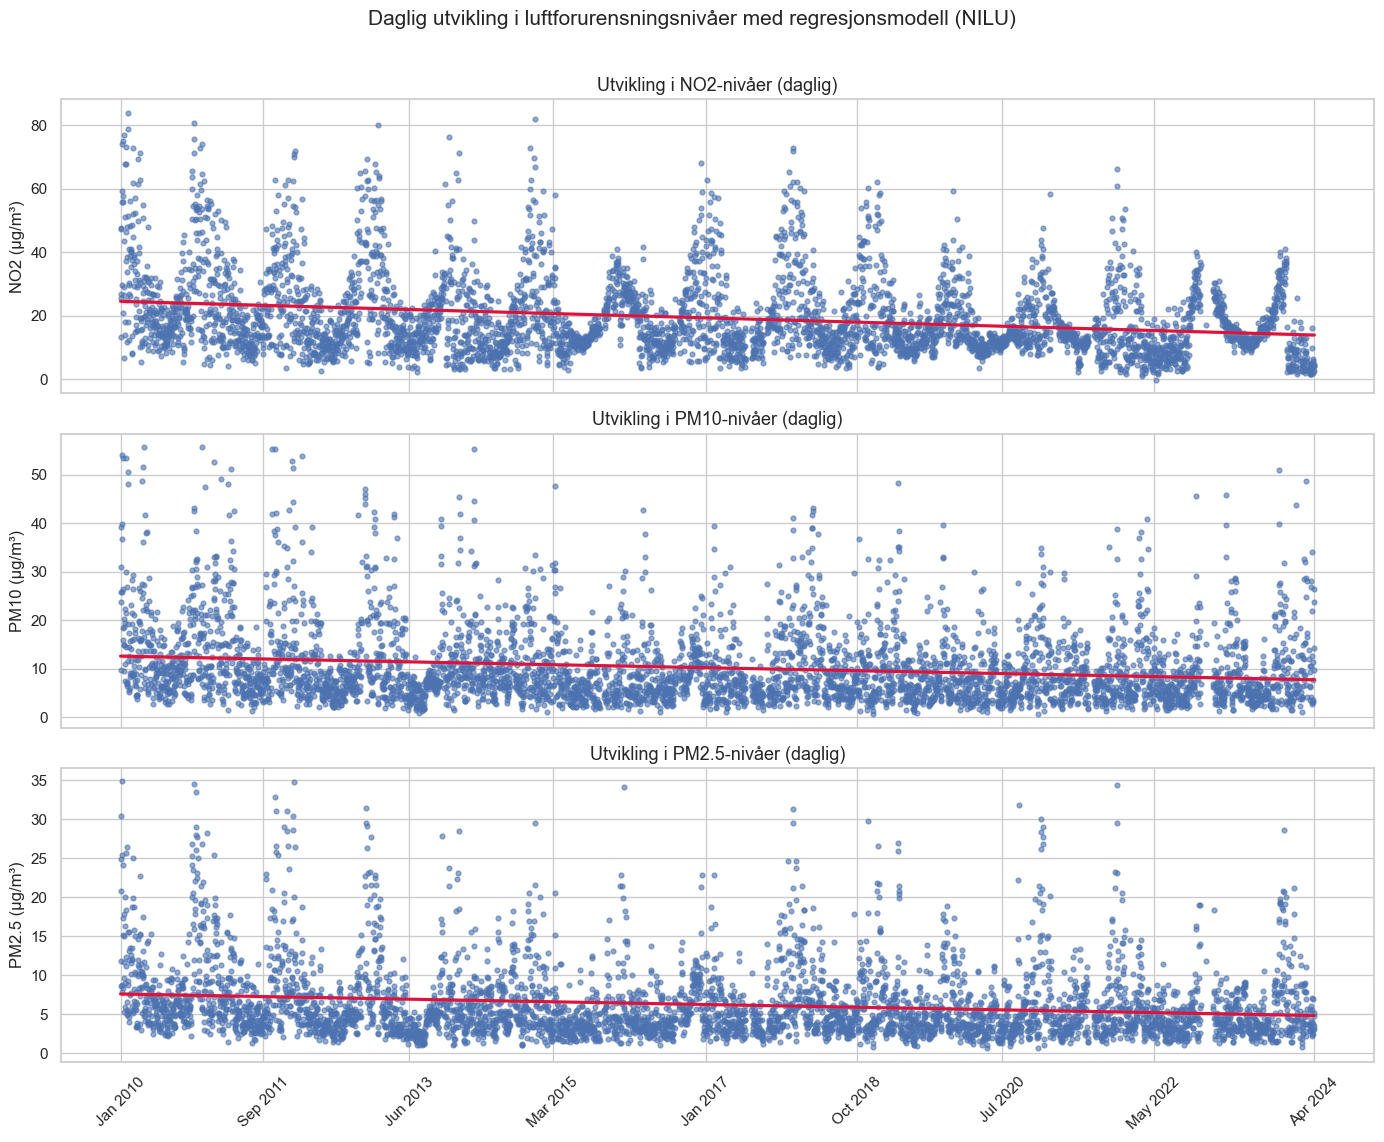

In [10]:
from data_visualizations.nilu_visualization.daily_pollution_trend_regression import vis_luftkvalitet_regresjon_nilu
vis_luftkvalitet_regresjon_nilu("../data/clean/cleaned_data_nilu.json")

### **Analyse:**

**Sesongvariasjon:**
- Den mest iøynefallende egenskapen er det repeterende **sesongmønsteret**, med **systematiske vintertopper** og **sommerdaler** i alle tre komponentene.
- Disse svingningene samsvarer med kjente lokale fenomener som **fyringssesong**, **temperaturinversjon**, **lite vind**, og **svevestøv fra piggdekk**.

**Langsiktig Trend:**
- Den røde regresjonslinjen har en **tydelig negativ helning** i alle tre grafer:
  - **NO₂**: Nedadgående trend i nitrogendioksid, sannsynligvis relatert til redusert bilbruk med fossilt brensel og bedre kjøretøyteknologi.
  - **PM10 og PM2.5**: Partikkelnivåene synker også over tid – noe som peker mot effekt av tiltak som støvdemping, feiepraksis og overgangen til piggfri kjøring.

**Konklusjon:**

Til tross for at vintermånedene fremdeles domineres av topper med høy forurensning, viser **alle tre komponenter en langsiktig, statistisk signifikant forbedring** i luftkvaliteten over den siste 10–15 årsperioden. 

---

#### **Figur 4: Sesongmessig Fordeling av NO₂-konsentrasjoner (Boxplot) 📊**

For å utdype forståelsen av den sesongmessige dynamikken som ble observert i de foregående figurene, presenteres her et boxplot av de månedlige NO₂-nivåene. her samles daglig utslipp i hver måned (forklaring av elementer i en boxplot er forklart tidligere i Figur 3: Månedlig Fordeling av Temperatur i Trondheim (Boxplot), derfor har vi valgt å ikke skrive det igjen)



 **Figurens formål**
* Visualisere og sammenligne den statistiske fordelingen av NO₂-nivåer for hver enkelt måned.
* Gi innsikt i både de typiske nivåene (**median**) og graden av **variabilitet** (størrelsen på boksen og whiskers).
* Identifisere hvilke måneder som har høyest, lavest, mest stabile og mest variable forurensningsnivåer.


- **Lesbarhet:** Figurens struktur gjør det lett å sammenligne måneder.
- **Estetikk:** Bruken av farger og standardisert skala gir et ryddig inntrykk, her kunne vi ha skillet fargene mer mellom sessongene
- **Formidling:** Visualiseringen viser tydelige sesongvariasjoner og støtter argumentet om vinterforurensning.


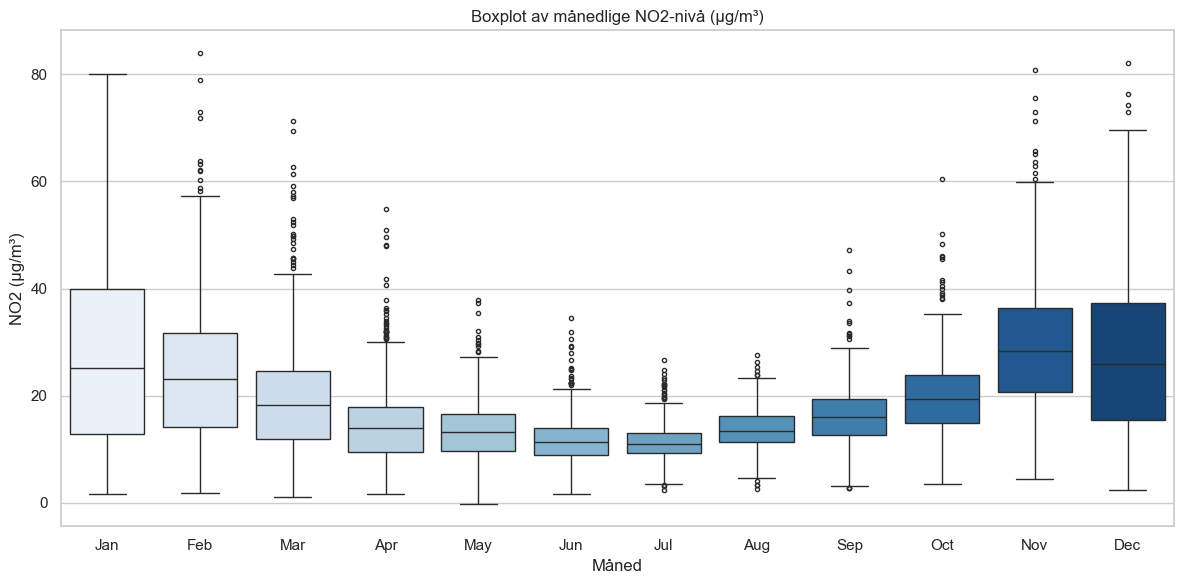

In [11]:
from data_visualizations.nilu_visualization.no2_boxplot_by_month import vis_no2_per_måned
vis_no2_per_måned('../data/clean/cleaned_data_nilu.json')

#### Analyse

**Sesongsyklus i Medianverdier**
- NO₂-nivåene viser fortsatt en klar **U-formet** kurve gjennom året.
  - Høyest i vintermånedene: **november, desember, januar og februar**.
  - Lavest i sommermånedene: **juni, juli og august** (med juli som renest).
  - Vår og høst fungerer som gradvise overgangsperioder.

**Variabilitet: Fra Stabile Somre til Uforutsigbare Vintre**
- Vintermånedene har **store bokser og lange whiskers**, som indikerer høy variasjon og uforutsigbarhet.
- Sommermånedene har **små bokser og korte whiskers**, noe som viser stabile og jevnt lave nivåer.

**Uteliggere og ekstremverdier**
- I denne figuren er uteliggere (små prikker utenfor whiskers) synliggjort. Disse representerer dager med uvanlig høye NO₂-nivåer sammenlignet med resten av måneden.
- At det fortsatt oppstår mange uteliggere, særlig om vinteren, reflekterer naturlig variasjon i luftkvalitet – for eksempel enkeltdager med spesielle værforhold, økt trafikk eller andre lokale utslipp.
- Uteliggere gir et mer fullstendig bilde av ekstreme hendelser, og tydeliggjør at noen dager kan ha betydelig høyere forurensning enn gjennomsnittet.
- Ekstreme målefeil og åpenbare feilkilder er allerede fjernet i datarensingen, slik at uteliggerne i figuren representerer reelle variasjoner og ikke feil.

**Oppsummering**
- Boxplottet bekrefter tydelig mønstrene fra tidsserieanalysen.
- Vinteren utgjør en dobbel utfordring:
  - Høyere gjennomsnittlig forurensning.
  - Større variasjon og mange dager med ekstra høye utslipp (uteliggere).
- Sommeren gir både lavere og mer stabile nivåer, med færre uteliggere.
- Ved å inkludere uteliggere i figuren får vi et mer ærlig og utfyllende bilde av variasjonen i NO₂-nivåene i Trondheim gjennom året.

---

#### **Figur 5: Sesongmessig Fordeling av PM10-konsentrasjoner (Boxplot) 🌬️**

Dette boxplottet viser den månedlige fordelingen av PM10-konsentrasjoner basert på daglige målinger. Formålet er å sammenligne sesongmønsteret for PM10 med det for NO₂.

**Figurens formål**
* Visualisere og sammenligne den statistiske fordelingen av PM10-nivåer gjennom året.
* Identifisere månedene med høyest nivåer og størst variasjon i svevestøv.
* Avdekke forskjeller i sesongdynamikk mellom PM10 og NO₂.


- **Lesbarhet:** God oppdeling og sammenlignbarhet med NO₂-plottet.
- **Estetikk:** Ensartet stilvalg gir konsistens og gjenkjennelighet.
- **Formidling:** Viser hvordan partikkelnivåene varierer med sesong og gir grunnlag for sammenligning mellom ulike forurensningstyper.

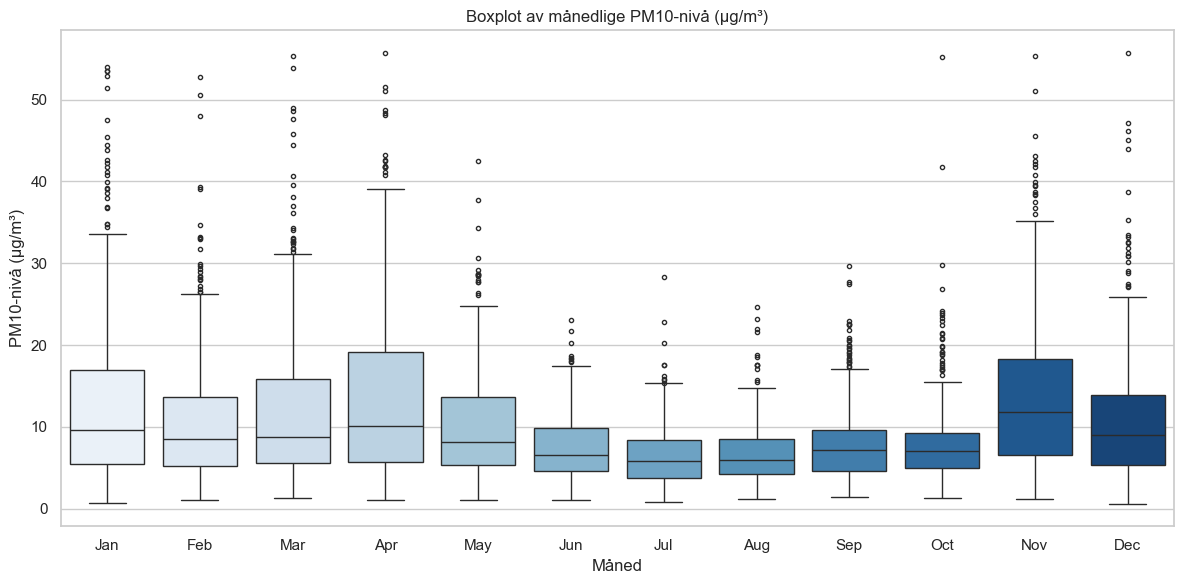

In [12]:
from data_visualizations.nilu_visualization.pm10_boxplot_by_month import vis_pm10_per_måned
vis_pm10_per_måned(('../data/clean/cleaned_data_nilu.json'))

#### Analyse

**Sesongmønster med vår-topp**
- Høyest median PM10-nivå i **april**, ikke midtvinters som for NO₂.
- April-toppen kan skyldes oppvirvling av veistøv som har samlet seg gjennom vinteren når snø og is smelter.
- Vintermånedene (f.eks. november og januar) har også forhøyede nivåer, men lavere enn april.
- Lavest og mest stabile nivåer i sommermånedene (juni, juli, august).

**Variabilitet: Stor spredning i april**
- April har store bokser og lange whiskers, som viser høy variasjon og risiko for dager med ekstremt høy forurensning.
    - Dette gjelder også vintersessongen, men i litt mindre grad
- Sommermånedene har små bokser og korte whiskers, som indikerer stabile og lave nivåer.

**Tolkning av uteliggere**
- Uteliggerne i figuren representerer dager med uvanlig høy forurensning, ofte knyttet til spesielle værforhold, ekstra mye trafikk, eller perioder med mye veistøv.
- Å vise uteliggere gir et mer ærlig bilde av naturlig variasjon og ekstremverdier, og gjør det mulig å identifisere episoder som kan være viktige for helse og tiltak.
- Ekstreme målefeil er allerede fjernet i datarensingen, slik at uteliggerne i figuren antas å skyldes reelle forhold.

**Oppsummering**
- PM10-forurensning topper om våren, i motsetning til NO₂ som topper om vinteren.
- Forskjellige forurensningskilder krever ulike tiltak tilpasset sesongen.

---

#### **Figur 6: Analyse mellom PM10 og NO₂ per Sesong 🔗**

Denne figuren viser sammenhengen mellom daglige nivåer av PM10 og NO₂, delt opp etter årstid. Det er laget fire spredningsplott (scatter plots), ett for hver sesong. Hvert punkt viser én dag, og en rett linje med usikkerhet (konfidensintervall) viser hvordan de to stoffene henger sammen.

**Figurens formål:**
* Vise sammenhengen mellom PM10 og NO₂ på daglig nivå.
* Måle hvor sterk og hvilken retning korrelasjonen har for hver sesong.
* Sjekke om forholdet mellom PM10 og NO₂ er likt hele året.


- **Lesbarhet:** Klar fargekoding per sesong, tydelige akser og regresjonslinjer gjør det enkelt å skille mønstrene.
- **Estetikk:** Bruken av separate trendlinjer og god plassering av punktene gir høy visuell kvalitet og lav visuell støy.
- **Formidling:** Figuren synliggjør hvordan sammenhengen mellom forurensningskomponentene varierer gjennom året, og gjør det lett å oppdage sesongspesifikke korrelasjoner som ellers kunne gått tapt i en samlet analyse.

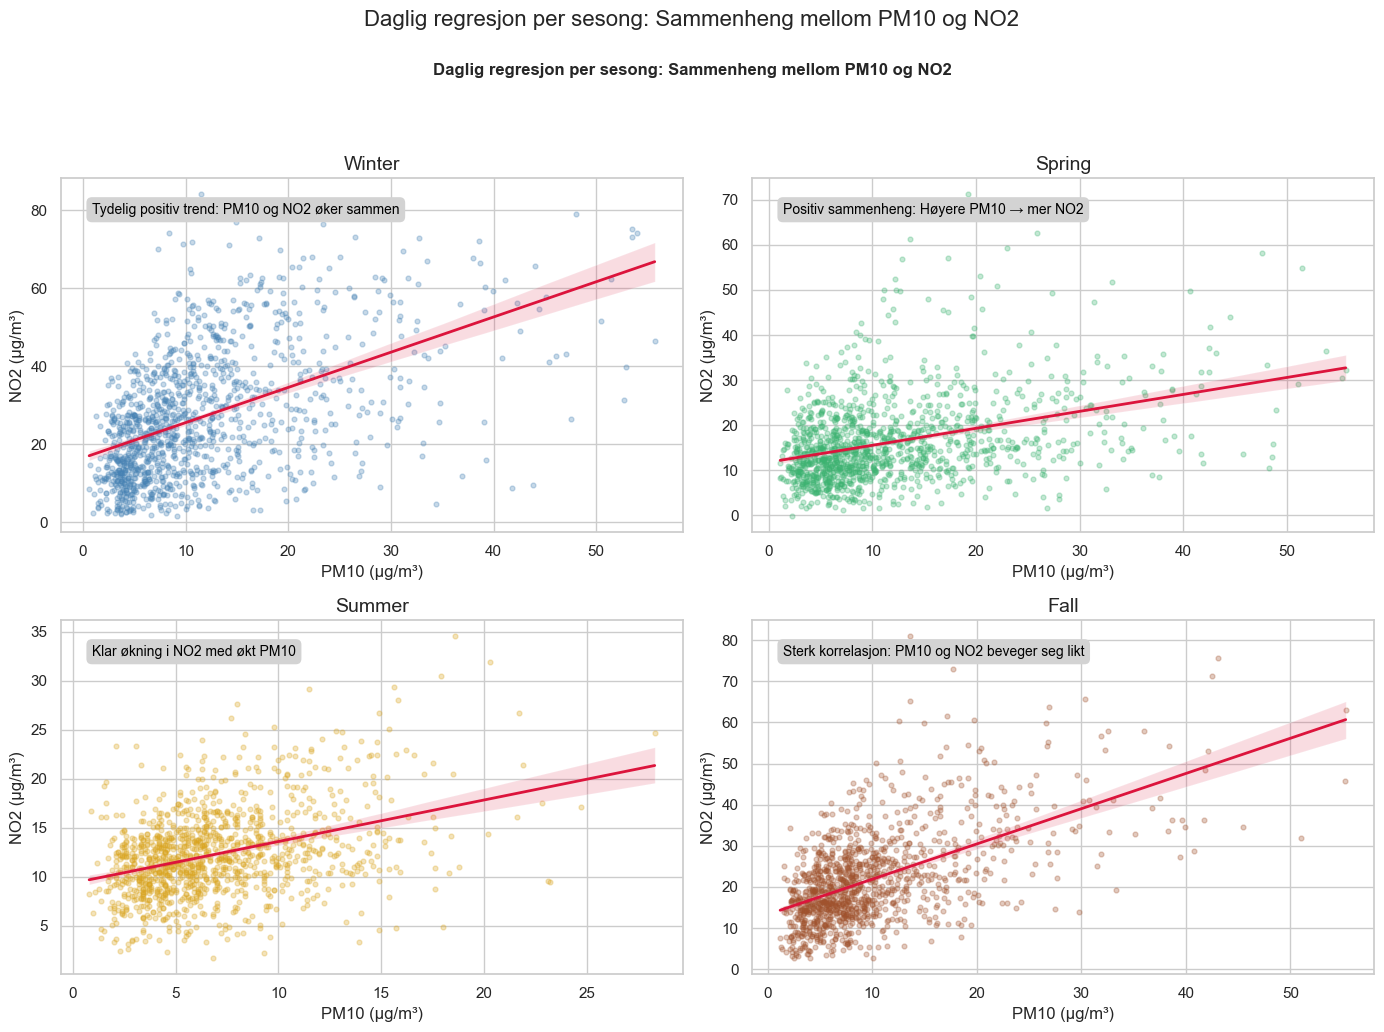

In [13]:
from data_visualizations.nilu_visualization.NO2_vs_PM10 import vis_pm10_vs_no2_per_sesong
vis_pm10_vs_no2_per_sesong("../data/clean/cleaned_data_nilu.json")

#### Analyse

**Positiv sammenheng hele året**
- Det er en klar positiv sammenheng i alle fire sesonger.
- Når PM10-nivåene er høye, er ofte også NO₂-nivåene høye.
- Dette tyder på at de har felles kilder, som trafikk, eller påvirkes av samme værforhold som gjør at forurensning samler seg.

**Forskjeller mellom sesongene**
- Korrelasjonen er sterkest om høsten og vinteren. Punktene ligger nærmere linjen.
- Om våren sprer punktene seg mer, noe som viser at sammenhengen er svakere eller mer komplisert.
- Vinterens linje er brattest, noe som betyr at når PM10 øker, øker NO₂ enda mer i denne perioden.

#### Innsikt og betydning
PM10 og NO₂ henger tett sammen i Trondheim. Men siden styrken og formen på sammenhengen varierer med årstid, viser det at forurensningskildene ikke er de samme hele året. For eksempel gjør mye veistøv om våren at sammenhengen blir svakere, fordi veistøv ikke lager NO₂.

---

#### **Figur 7: Årlig Utvikling i Luftkvalitet per Sesong (Interaktiv)**

Denne figuren viser en interaktiv tidsserie av gjennomsnittlig luftkvaliteten fra 2010 til 2024, delt opp i fire paneler – ett for hver sesong. Den viser gjennomsnittlig nivå av NO₂, PM10 og PM2.5 hvert år. Dette gir en detaljert oversikt over hvordan luftforurensningen har utviklet seg år for år, sesong for sesong.

**Figurens formål:**
* Følge utviklingen av de tre forurensningskomponentene over tid.
* Sammenligne trendene i de ulike sesongene.
* Se hvordan nivåene av NO₂, PM10 og PM2.5 henger sammen innen hver sesong over årene.


- **Lesbarhet:** Brukeren kan enkelt navigere og hente ut detaljer fra ulike perioder.
- **Estetikk:** Interaktiv layout og fargebruk gir oversikt og dybde.
- **Formidling:** Fremhever tydelige sesongvariasjoner og gir god støtte til analysen av typiske og ekstreme verdier.


In [14]:
from data_visualizations.nilu_visualization.nilu_interactive_visualization import plot_seasonal_air_quality
plot_seasonal_air_quality("../data/clean/cleaned_data_nilu.json")

**Analyse av figuren:**

* **Bekreftelse av Sesongmønstre:**
    * Figuren gir en tydelig bekreftelse av de sesongmessige mønstrene som er identifisert tidligere.
    * **NO₂ (blå linje)** viser den mest dramatiske forskjellen mellom sesongene, med konsekvent høyest konsentrasjon om vinteren.
    * **PM10 (rød linje) og PM2.5 (grønn linje)** følger hverandre tett, som forventet, og viser også et mønster med generelt høyere nivåer i de kaldere månedene og lavere om sommeren.


**Innsikt og relevans:**
Denne figuren bygger bro mellom de foregående analysene. Den tar den enkle konklusjonen fra regresjonslinjen ("det blir bedre") og gir den en detaljert, årlig fortelling. Man kan se hvilke år som var spesielt gode eller dårlige, og hvordan forbedringen ikke har vært jevn, men har skjedd i rykk og napp. 

---

## Del 4 -  Korrelasjoner og sammenhenger 📊🔗

Her går vi dypere i statistikken for å finne sammenhenger mellom miljøvariablene. Vi bruker korrelasjonsmatriser og scatterplots med regresjonslinjer for å se hvilke variabler som henger sammen, og hvordan endringer i én påvirker en annen. Målet er å identifisere og tolke viktige koblinger som kan forklare mønstrene vi har sett tidligere.


#### **Figur 1: Kvantifisert Sammenheng – Korrelasjonsmatriser** 🔢

Denne figuren viser to korrelasjonsmatriser som heatmaps, satt opp side om side for enkel sammenligning. Den venstre matrisen viser sammenhengen mellom de viktigste værvariablene (temperatur, nedbør og vind). Den høyre matrisen viser sammenhengen mellom de tre luftforurensningskomponentene (NO₂, PM10 og PM2.5). Fargene i rutene viser hvor sterk og hvilken retning korrelasjonen har – fra beige (ingen eller veldig svak sammenheng) til mørkerød (sterk positiv sammenheng).

**Figurens formål:**
Formålet med denne figuren er å:
* Måle og vise hvor sterkt variablene henger sammen.
* Sammenligne hvordan værvariablene henger sammen med hvordan forurensningskomponentene henger sammen.
* Gi konkrete tall som bekrefter det vi så i spredningsplottene i Figur 6.

- **Lesbarhet:** Fargegradering og numeriske verdier i rutene gjør det lett å se hvilke variabler som har sterk eller svak korrelasjon.
- **Estetikk:** Rent uttrykk med god bruk av varme/kulde-farger. Rutenettet gir god oversikt og gjør det visuelt lett å tolke.
- **Formidling:** Fremhever hvilke sammenhenger som er verdt å undersøke videre, og fungerer som en effektiv inngangsport til videre analyse og regresjon.

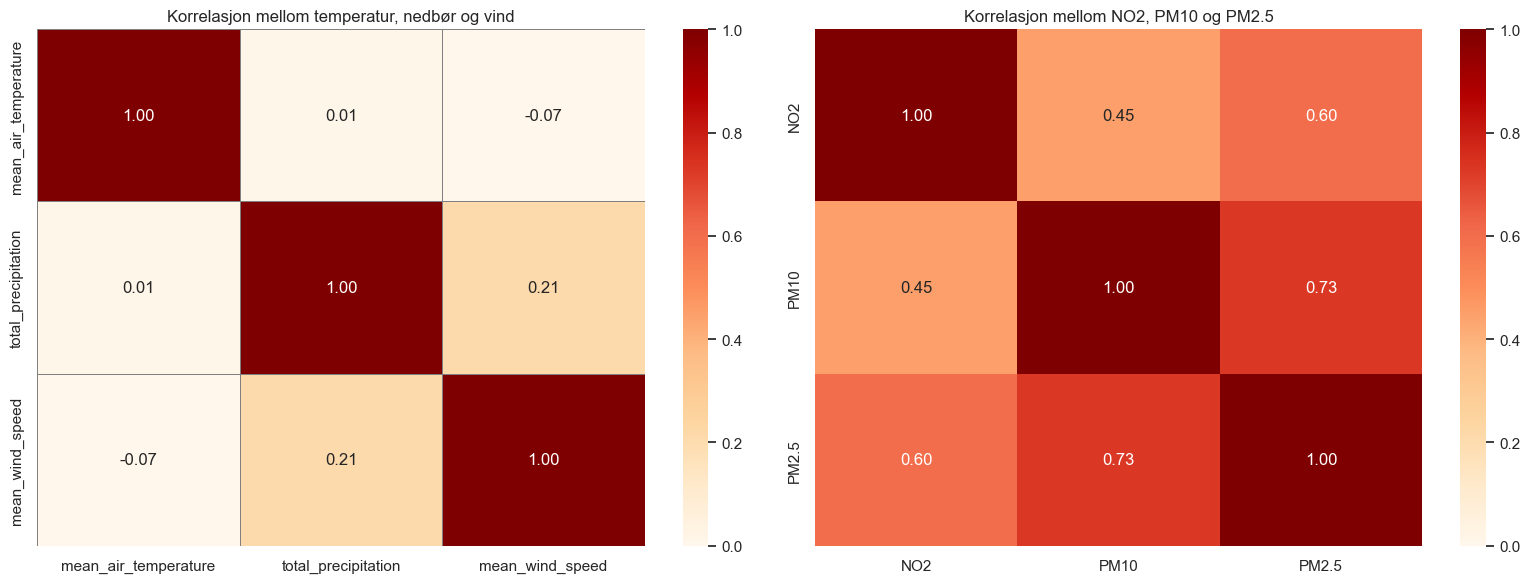

In [15]:
from data_visualizations.frost_vs_nilu_visualization.correlation import vis_korrelasjoner_sammen
vis_korrelasjoner_sammen("../data/analyses_results/frost_correlation_matrix.csv",
                        "../data/analyses_results/nilu_correlation_matrix.csv")


**Analyse av figuren:**

* **Venstre Plott (Værdata): Et System av Uavhengige Variabler**
    * I matrisen for værdata er korrelasjonskoeffisientene svært lave, med verdier tett på null (0.02, -0.07, 0.25).
    * Dette betyr at det i praksis ikke er noen meningsfull lineær sammenheng mellom gjennomsnittlig temperatur, nedbørsmengde og vindhastighet i det aggregerte datasettet. De opptrer som i hovedsak uavhengige faktorer.

* **Høyre Plott (Forurensningsdata): Et Tett Sammenknyttet System**
    * I sterk kontrast viser matrisen for forurensningsdata høye og positive korrelasjonskoeffisienter over hele fjøla.
    * Samtlige sammenhenger er moderat til sterkt positive: NO₂ vs. PM10 (0.55), NO₂ vs. PM2.5 (0.71) og PM10 vs. PM2.5 (0.77).
    * Dette viser med all tydelighet at forurensningskomponentene er sterkt korrelerte og **beveger seg i takt**. Når konsentrasjonen av én komponent øker, øker de andre også. Den sterkeste korrelasjonen er mellom PM10 og PM2.5 (0.77), noe som er logisk da PM2.5 er en delmengde av PM10.

**Innsikt og relevans:**

Denne figuren viser en forskjell mellom de to systemene, og gir oss konkrete tall som bekrefter det vi kunne se på spredningsplottene i figur 6.

Selv om den sterkeste sammenhengen i tall er mellom PM10 og PM2.5 (r=0,77), er dette som forventet, fordi PM2.5 er en del av PM10. Derfor var det mer interessant for oss å se nærmere på sammenhengen mellom **PM10 og NO₂**, selv om denne var litt svakere. Dette ble undersøkt i detalj i figur 6, fordi det gir bedre forståelse av hvilke utslippskilder og værforhold som påvirker dem begge.

Den tydelige positive sammenhengen mellom disse to (r=0,55) viser at de ofte har **samme kilder** (for eksempel veitrafikk) og/eller påvirkes av **samme værforhold** (som temperaturinversjon). Det betyr at når det ene øker eller minker, gjør det andre ofte det samme. Dette viser at tiltak som retter seg mot de felles årsakene, vil ha en bred og positiv effekt på luftkvaliteten generelt.

---

#### **Figur 2: Analyse på Tvers av Datasett – Temperatur vs. PM2.5** 🌦️

Denne figuren viser en mer avansert analyse, der målet er å undersøke om det finnes en sammenheng mellom variabler fra **to ulike datasett**: temperaturdata hentet fra FROST-APIet og PM2.5-data fra NILU. Ved å plotte de daglige verdiene mot hverandre, kan vi se om temperatur har en direkte og målbar effekt på forurensningsnivåene, og om denne effekten er den samme gjennom hele året.

**Figurens formål:**
- Undersøke om det finnes en statistisk sammenheng mellom temperatur (en meteorologisk variabel) og PM2.5 (en luftforurensningskomponent).
- Finne ut om denne sammenhengen er lik hele året, eller om den endrer seg mellom årstidene.
- Teste om det stemmer at kaldt vær gir høyere forurensning.


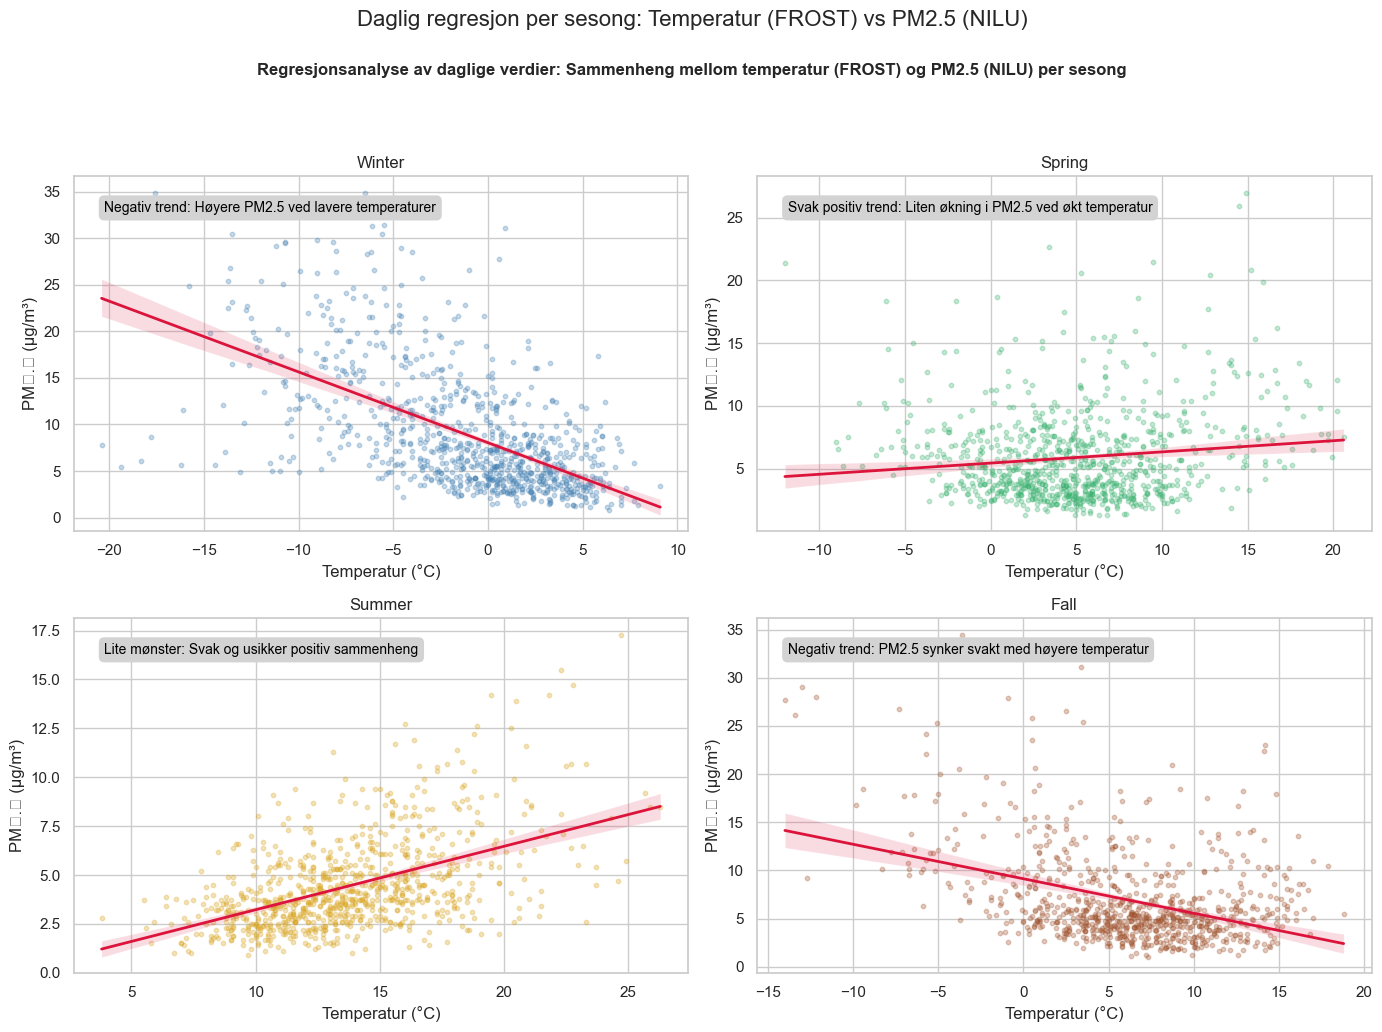

In [16]:
from data_visualizations.frost_vs_nilu_visualization.Temperature_vs_NO2 import plot_temperature_vs_pm25
plot_temperature_vs_pm25(
    "../data/clean/cleaned_data_nilu.json",
    "../data/clean/frost.db"
)

**Analyse av figuren:**

* **Komplekst og Sesongavhengig Forhold:**
    Figuren avslører et **komplekst og tydelig sesongavhengig mønster**. Forholdet mellom temperatur og PM2.5 er ikke det samme hele året, men varierer mye etter årstid.

* **Tydelig Negativ Korrelasjon om Vinter og Høst:**
    * I **vinter- og høst-panelet** ser vi en **sterk negativ sammenheng** (den røde linjen peker tydelig nedover).
    * Dette betyr at **jo lavere temperaturen er, desto høyere blir PM2.5-konsentrasjonen**. Dette gir støtte til teorien om at kalde forhold, trolig på grunn av temperaturinversjoner og økt fyring, fører til mer forurensning.

* **Svak Positiv Korrelasjon om Våren og Sommeren:**
    * Om **våren og sommeren** er sammenhengen motsatt, men mye svakere – det vil si, litt høyere temperatur gir litt høyere PM2.5-nivåer.
    * Som det står i sommer-panelet, er denne sammenhengen "svak og usikker". På denne tiden av året er det sannsynligvis andre faktorer enn temperatur som har større betydning for PM2.5-nivåene, som vind, regn eller spesielle utslipp.

**Innsikt og relevans:**
Det viktigste vi lærer av denne figuren, er at forholdet mellom temperatur og luftforurensning ikke kan forklares med én enkel regel. Analysen viser tydelig at **kalde temperaturer gir økt PM2.5-forurensning**, noe som er viktig å vite for varsling og tiltak om vinteren. At dette mønsteret ikke gjelder om sommeren, viser at vi må bruke forskjellige modeller og forståelser for forurensning avhengig av årstid. Denne analysen viser hvorfor det er smart å analysere dataene hver sesong for seg, siden en samlet analyse for hele året ville skjult disse motstridende trendene og gitt et feil bilde.

---

## 🔚 Oppsummering: Luftkvalitetsanalysen i Trondheim – Hva Har Vi Lært?

Etter å ha analysert daglige målinger av NO₂, PM10 og PM2.5 over flere år og koblet disse til meteorologiske data, har vi fått et tydelig og detaljert bilde av luftkvalitetens dynamikk i Trondheim.

### 🍂 Sesongvariasjoner
- Luftforurensning følger klare sesongmønstre: vinteren er verst med høyest konsentrasjon av både NO₂ og partikler, mens sommeren er renest.
- Vår og høst viser mer variabel luftkvalitet, men fortsatt tydelige mønstre som understøtter sesonginndelingen.

### 🔗 Sammenhenger mellom forurensningskomponenter
- PM10 og NO₂ har en gjennomgående positiv korrelasjon, spesielt sterk om høsten og vinteren. Dette tyder på at de deler kilder, som veitrafikk, og påvirkes av samme værfenomener.
- PM10 og PM2.5 henger enda tettere sammen, noe som er forventet siden PM2.5 er en delmengde av PM10.


### 🌬️ Meteorologi vs. Forurensning
- Temperatur, vind og nedbør opptrer i stor grad som uavhengige variabler.
- Forurensningskomponentene beveger seg derimot i takt og påvirkes i stor grad av felles kilder og atmosfæriske forhold.

### 📈 Årlige trender og variasjoner
- Luftkvaliteten har bedret seg i flere perioder, men forbedringen har ikke vært jevn eller konstant. Noen år har vært bedre enn andre.
---

**Konklusjon:**  
Luftkvaliteten i Trondheim styres av flere samspillende faktorer – sesong, forurensningskilder og meteorologiske forhold. For å få reell effekt av tiltak, må man forstå denne kompleksiteten og tilpasse innsatsen etter både sesong og type forurensning. Enkle løsninger fungerer ikke, men med dette datagrunnlaget er vi bedre rustet til å forbedre lufta vi puster inn.

Luftkvalitet er komplisert, men nå har vi fakta som gir oss et klart bilde. Det er nå jobben starter med å bruke denne innsikten til reell forbedring.

### [**Videre til analyse og visualisering**](03_predictive_analysis.ipynb)
##### [**Til samlesiden**](../docs/samleside.md)

